In [18]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import os

data = 'balanced_04_vel20/'
path = '/home/luiz/my_projects/crazyflie/crazyflie_controller/src/data/csv_data/' + data
save_image_path = '/home/luiz/my_projects/crazyflie/crazyflie_controller/src/data/images/' + data

save_flag = False
cut_data = True

if not os.path.exists(save_image_path):
    os.makedirs(save_image_path)

### CSV's available
# control_ref.csv
# control_sent.csv
# desired_position.csv
# desired_velocity.csv
# orientation_optitrack.csv
# pitch_roll_crazyflie.csv
# position_gaussian_error.csv
# position_kalman.csv
# position_optitrack.csv
# reference_vel.csv
# thrust_crazyflie.csv
# time.csv
# vel_crazyflie.csv
# vel_kalmam.csv
# vel_optitrack.csv
# yaw_angle_crazyflie.csv
# z_crazyflie.csv

# Load the data from CSV files
time = os.path.join(path, 'time.csv')

### Velocity
desired_velocity_path = os.path.join(path, 'desired_velocity.csv')
vel_optitrack_path = os.path.join(path, 'vel_optitrack.csv')
vel_kalman_path = os.path.join(path, 'vel_kalmam.csv')
vel_crazyflie_path = os.path.join(path, 'vel_crazyflie.csv')

### Orientation
orientation_optitrack_path = os.path.join(path, 'orientation_optitrack.csv')
yaw_angle_crazyflie_path = os.path.join(path, 'yaw_angle_crazyflie.csv')

# Load the data from CSV files
time = pd.read_csv(time)
desired_velocity = pd.read_csv(desired_velocity_path)
vel_optitrack = pd.read_csv(vel_optitrack_path)
vel_kalman = pd.read_csv(vel_kalman_path)
vel_crazyflie = pd.read_csv(vel_crazyflie_path)

orientation_optitrack = pd.read_csv(orientation_optitrack_path)
yaw_crazyflie = pd.read_csv(yaw_angle_crazyflie_path)

# Tranforming the data into numpy arrays
time = time.values
desired_velocity = desired_velocity.values
vel_optitrack_world= vel_optitrack.values
vel_kalman_body = vel_kalman.values
vel_crazyflie_world = vel_crazyflie.values
orientation_optitrack = orientation_optitrack.values
yaw_crazyflie = np.deg2rad(yaw_crazyflie.values)

### Limit the data to a specific time
if cut_data:
    start = 1
    end = 20

    len_time = len(time)
    max_time = time[len_time-1]

    start_index = int(start*len_time/max_time)
    end_index = int(end*len_time/max_time)

    time = np.array(time[start_index:end_index])
    desired_velocity = np.array(desired_velocity[start_index:end_index])
    vel_optitrack_world = np.array(vel_optitrack_world[start_index:end_index])
    vel_kalman_body = np.array(vel_kalman_body[start_index:end_index])
    vel_crazyflie_world = np.array(vel_crazyflie_world[start_index:end_index])
    orientation_optitrack = np.array(orientation_optitrack[start_index:end_index])
    yaw_crazyflie = np.array(yaw_crazyflie[start_index:end_index])

In [ ]:
import numpy as np
from scipy.signal import find_peaks

def calculate_data_delay(time, dataset1, dataset2):
    """
    Calculate the delay between two datasets over time.

    Parameters:
    - time: Array of time stamps.
    - dataset1: First dataset array (e.g., desired data).
    - dataset2: Second dataset array (e.g., measured data from sensors).
    - calculate_rmse: A function that calculates the Root Mean Square Error between two arrays.

    Returns:
    - time_delay: The delay time corresponding to the first significant change in error, if any.
    - deriv: The derivative of the RMSE values.
    - peaks: The indices of the peaks in the RMSE derivative.
    """
    # deriv = []
    index_of_delay = 0
    rmse_no_delay = 0

    for i in range(len(time)):
        # Adjust the arrays based on the current offset
        dataset2_cut = np.array(dataset2[i:])
        if i == 0:
            dataset1_cut = np.array(dataset1)
        else:
            dataset1_cut = np.array(dataset1[:-i])

        # Calculate the RMSE for the adjusted datasets
        rmse_current =  np.sqrt(np.mean((dataset2_cut - dataset1_cut) ** 2))
        
        # # Calculate the derivative of RMSE
        if i == 0:
            rmse_old = rmse_current
            continue

        # deriv.append(rmse_current - rmse_old)
        if (rmse_current - rmse_old) > 0:
            index_of_delay = i - 1
            rmse_no_delay = rmse_old
            break

        rmse_old = rmse_current

    time_delay = time[index_of_delay]
    time_delay = time_delay - time[0]

    return time_delay[0], rmse_no_delay, index_of_delay


# Calculate the delay between the desired velocity and the real velocity
time_delay, rmse_no_delay, index_of_delay = calculate_data_delay(time, desired_velocity, vel_kalman_world)

plt.figure(figsize=(10, 7))
if index_of_delay == 0:
    plt.plot(time, desired_velocity[:, 2], label='Desired Y', linestyle='--', color='blue')
    plt.plot(time, vel_kalman_world[:, 2], label='OptiTrack Y', linestyle='-.', color='red', alpha=1, linewidth=2)
else:
    desired_position_cut = desired_velocity[:-index_of_delay, 2]
    position_kalman_cut = vel_kalman_world[index_of_delay:, 2]

time_cut = time[:-index_of_delay]

plt.plot(time_cut, desired_position_cut, label='Desired Y', linestyle='--', color='blue')
plt.plot(time_cut, position_kalman_cut, label='Kalman Y', linestyle='-', color='green')

plt.title('Position Comparison: Desired vs. Kalman (Y Dimension) Without delay')
plt.xlabel('Time (s)')
plt.ylabel('Position (Y)')
plt.legend()
plt.grid(True)
plt.show()
print(time_delay)
print(rmse_no_delay)

In [19]:
def rotation_body_to_world(orientation, vector):
    R = np.array([[np.cos(orientation) , -np.sin(orientation)], 
                  [np.sin(orientation) , np.cos(orientation)]])
    return np.dot(R, vector)

def rotation_world_to_body(orientation, vector):
    R = np.array([[np.cos(orientation) , np.sin(orientation)], 
                  [-np.sin(orientation), np.cos(orientation)]])
    return np.dot(R, vector)

In [20]:
# ### Rotation matricies
# quaternion = [x, y, z, w]  # Replace these with your actual quaternion values

# # Create a rotation object from the quaternion
# rotation = R.from_quat(quaternion)

# # Convert the quaternion to Euler angles (in radians)
# euler_angles_radians = rotation.as_euler('xyz', degrees=False)
orientation_optitrack_rad = np.array([R.from_quat(orientation).as_euler('xyz', degrees=False) for orientation in orientation_optitrack])

vel_kalman_world = np.zeros((len(time), 3))
vel_optitrack_body = np.zeros((len(time), 3))
vel_crazyflie_body = np.zeros((len(time), 3))

for i in range(len(time)):
    vel_crazyflie_body[i, 0:2] = rotation_world_to_body(yaw_crazyflie[i,0], vel_crazyflie_world[i, 0:2])
    vel_crazyflie_body[i, 2] = vel_crazyflie_world[i, 2]

    vel_optitrack_body[i, 0:2] = rotation_world_to_body(orientation_optitrack_rad[i, 2], vel_optitrack_world[i, 0:2])
    vel_optitrack_body[i, 2] = vel_optitrack_world[i, 2]

    vel_kalman_world[i, 0:2] = rotation_body_to_world(yaw_crazyflie[i, 0], vel_kalman_body[i, 0:2])
    vel_kalman_world[i, 2] = vel_kalman_body[i, 2]

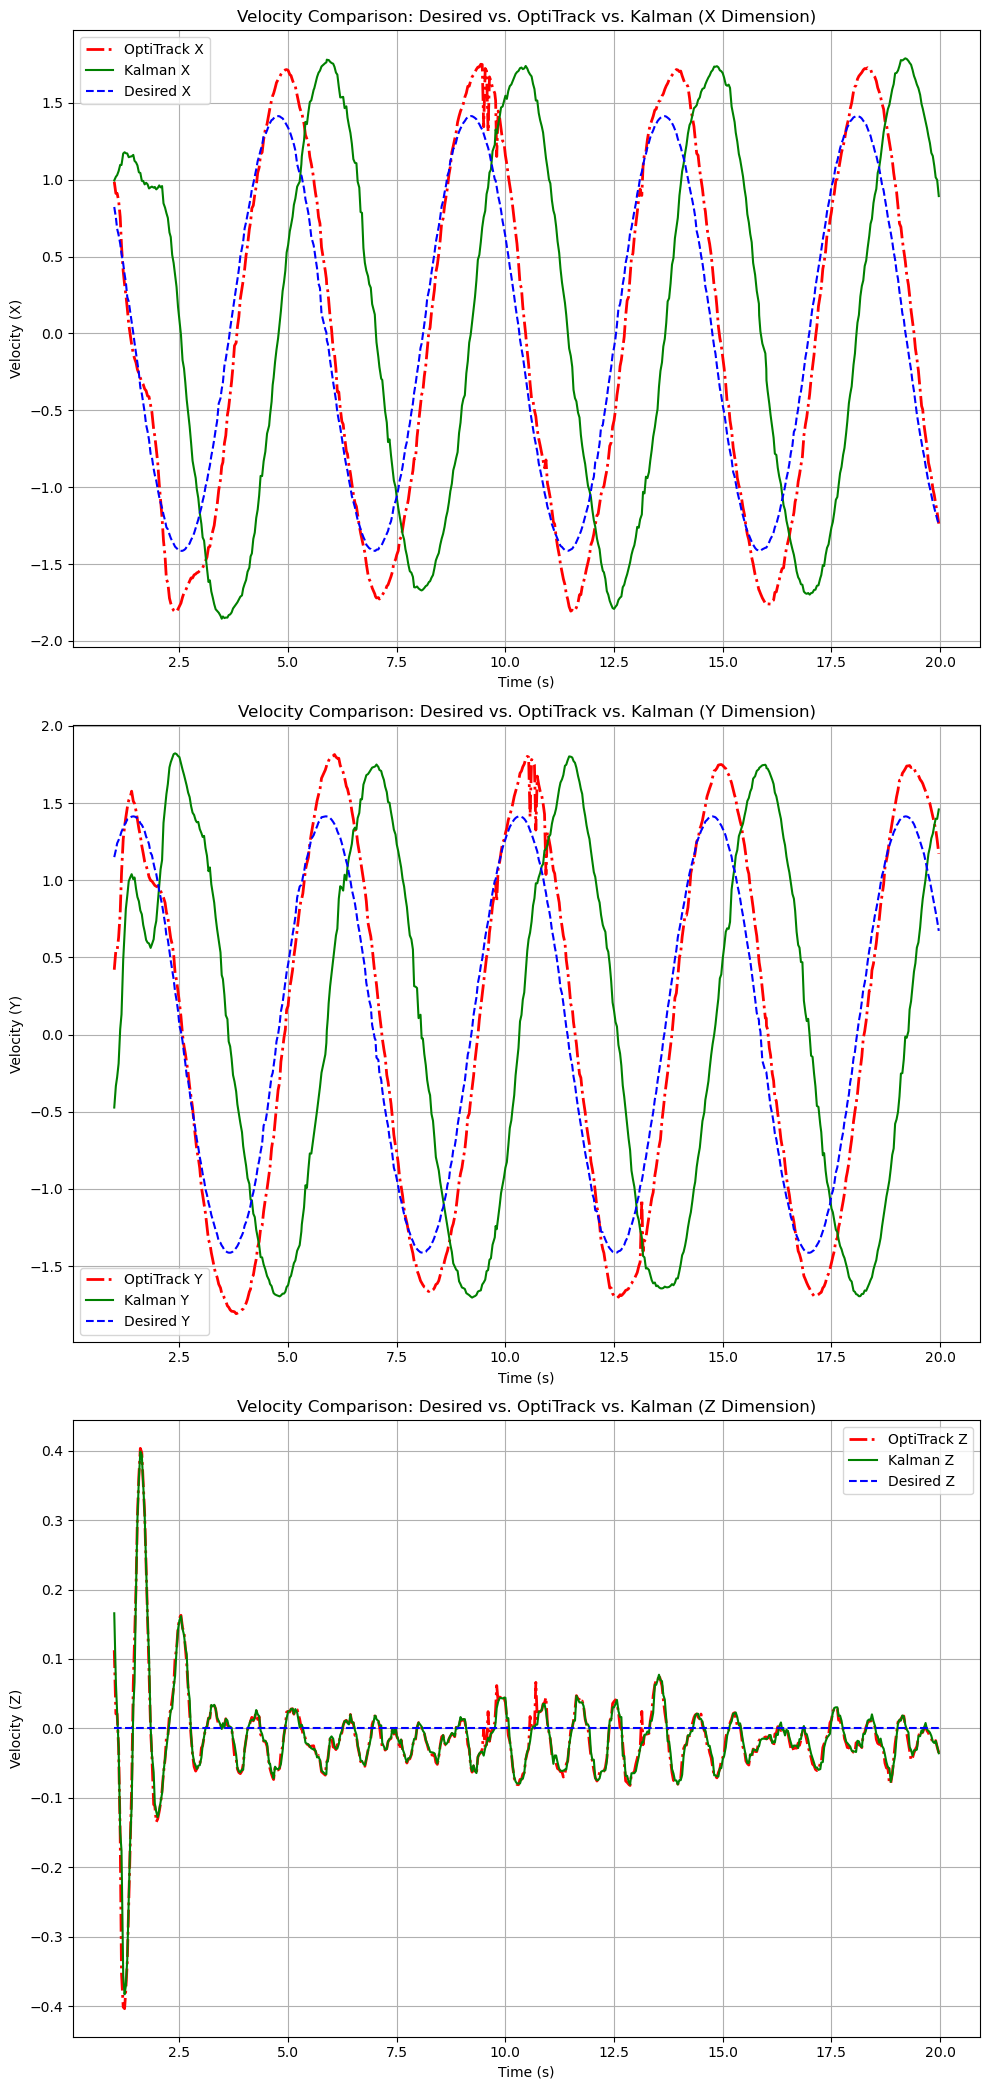

In [30]:
### Velocity tracking

fig, axs = plt.subplots(3, 1, figsize=(10, 21))  # 3 rows, 1 column

# X Dimension
axs[0].plot(time, vel_optitrack_world[:, 0], label='OptiTrack X', linestyle='-.', color='red', alpha=1, linewidth=2)
axs[0].plot(time, vel_kalman_world[:, 0], label='Kalman X', linestyle='-', color='green')
axs[0].plot(time, desired_velocity[:, 0], label='Desired X', linestyle='--', color='blue')
axs[0].set_title('Velocity Comparison: Desired vs. OptiTrack vs. Kalman (X Dimension)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Velocity (X)')
axs[0].legend()
axs[0].grid(True)

# Y Dimension
axs[1].plot(time, vel_optitrack_world[:, 1], label='OptiTrack Y', linestyle='-.', color='red', alpha=1, linewidth=2)
axs[1].plot(time, vel_kalman_world[:, 1], label='Kalman Y', linestyle='-', color='green')
axs[1].plot(time, desired_velocity[:, 1], label='Desired Y', linestyle='--', color='blue')
axs[1].set_title('Velocity Comparison: Desired vs. OptiTrack vs. Kalman (Y Dimension)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Velocity (Y)')
axs[1].legend()
axs[1].grid(True)

# Z Dimension
axs[2].plot(time, vel_optitrack_world[:, 2], label='OptiTrack Z', linestyle='-.', color='red', alpha=1, linewidth=2)
axs[2].plot(time, vel_kalman_world[:, 2], label='Kalman Z', linestyle='-', color='green')
axs[2].plot(time, desired_velocity[:, 2], label='Desired Z', linestyle='--', color='blue')
axs[2].set_title('Velocity Comparison: Desired vs. OptiTrack vs. Kalman (Z Dimension)')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Velocity (Z)')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


4 565


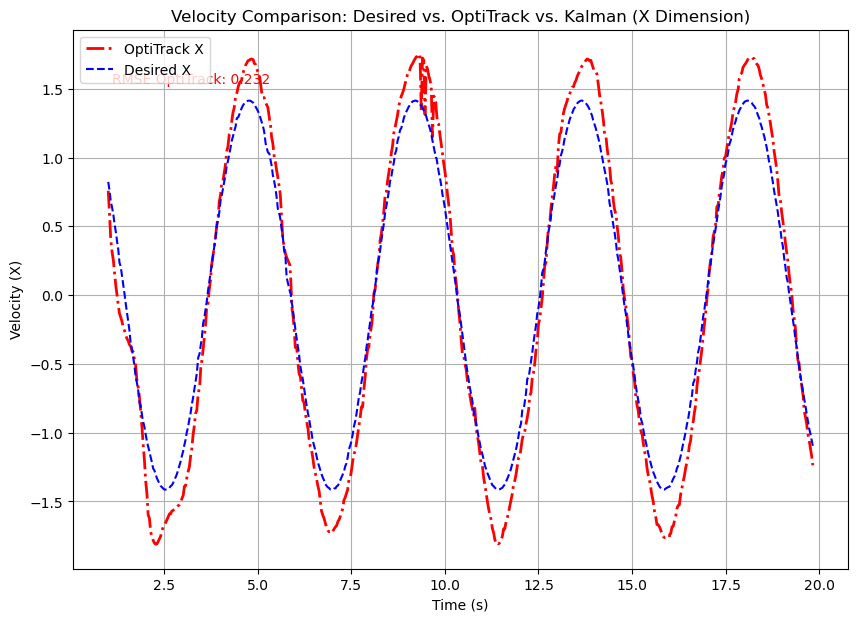

In [64]:
#### Erase 5 s on the vel_optitrack_world and vel_kalman_world

cut = 0.16683

len_time = len(time)
max_time = time[len_time-1]

start = cut
end = max_time - cut

start_index = int(start*len_time/max_time)
end_index = int(end*len_time/max_time)

print(start_index, end_index)

vel_optitrack_world_cut = np.array(vel_optitrack_world[start_index:])
#vel_kalman_world_cut = np.array(vel_kalman_world[start_index:])
desired_velocity_cut = np.array(desired_velocity[:end_index+1])

### Calculate the RMSE for the velocity cut
# rmse_vel_kalman = calculate_rmse(desired_velocity_cut[:, i], vel_kalman_world_cut[:, i])
rmse_vel_optitrack = calculate_rmse(desired_velocity_cut[:, 0], vel_optitrack_world_cut[:, 0])

new_time = time[:end_index+1]

plt.figure(figsize=(10, 7))
plt.plot(new_time, vel_optitrack_world_cut[:, 0], label='OptiTrack X', linestyle='-.', color='red', alpha=1, linewidth=2)
# plt.plot(new_time, vel_kalman_world_cut[:, 0], label='Kalman X', linestyle='-', color='green')
plt.plot(new_time, desired_velocity_cut[:, 0], label='Desired X', linestyle='--', color='blue')

plt.title('Velocity Comparison: Desired vs. OptiTrack vs. Kalman (X Dimension)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (X)')
plt.legend()
plt.grid(True)

### Include RMSE on plot
# plt.annotate(f'RMSE Kalman: {rmse_vel_kalman[0]:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='green')
plt.annotate(f'RMSE OptiTrack: {rmse_vel_optitrack:.3f}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10, color='red')

plt.show()

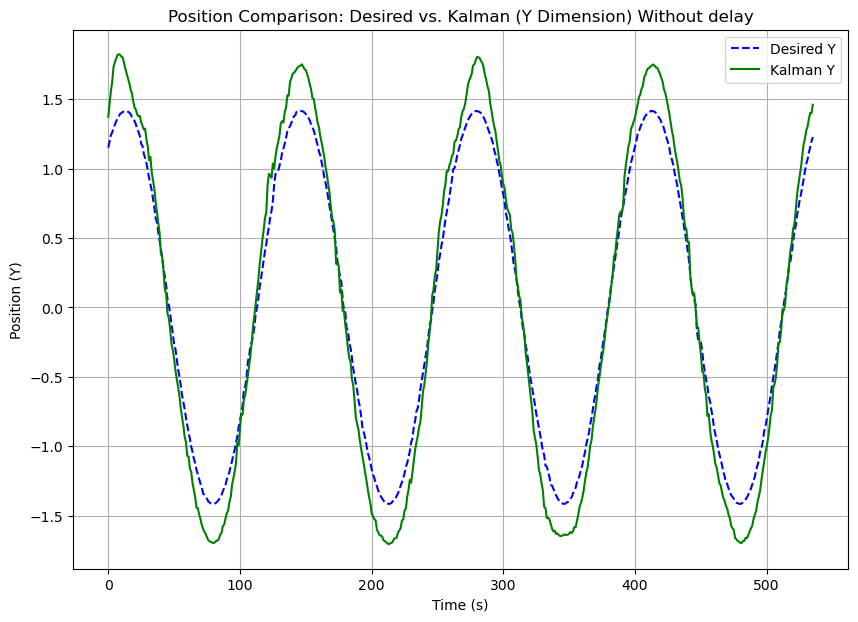

1.1332287788391118
0.2184112954263331


In [70]:
import numpy as np
from scipy.signal import find_peaks

def calculate_data_delay(time, dataset1, dataset2):
    """
    Calculate the delay between two datasets over time.

    Parameters:
    - time: Array of time stamps.
    - dataset1: First dataset array (e.g., desired data).
    - dataset2: Second dataset array (e.g., measured data from sensors).
    - calculate_rmse: A function that calculates the Root Mean Square Error between two arrays.

    Returns:
    - time_delay: The delay time corresponding to the first significant change in error, if any.
    - deriv: The derivative of the RMSE values.
    - peaks: The indices of the peaks in the RMSE derivative.
    """
    # deriv = []
    index_of_delay = 0
    rmse_no_delay = 0

    for i in range(len(time)):
        # Adjust the arrays based on the current offset
        dataset2_cut = np.array(dataset2[i:])
        if i == 0:
            dataset1_cut = np.array(dataset1)
        else:
            dataset1_cut = np.array(dataset1[:-i])

        # Calculate the RMSE for the adjusted datasets
        rmse_current =  np.sqrt(np.mean((dataset2_cut - dataset1_cut) ** 2))
        
        # # Calculate the derivative of RMSE
        if i == 0:
            rmse_old = rmse_current
            continue

        # deriv.append(rmse_current - rmse_old)
        if (rmse_current - rmse_old) > 0:
            index_of_delay = i - 1
            rmse_no_delay = rmse_old
            break

        rmse_old = rmse_current

    time_delay = time[index_of_delay]
    time_delay = time_delay - time[0]

    return time_delay[0], rmse_no_delay, index_of_delay


# Calculate the delay between the desired velocity and the real velocity
time_delay, rmse_no_delay, index_of_delay = calculate_data_delay(time, desired_velocity[:, 1], vel_kalman_world[:, 1])

plt.figure(figsize=(10, 7))
if index_of_delay == 0:
    plt.plot(time, desired_velocity[:, 1], label='Desired Y', linestyle='--', color='blue')
    plt.plot(time, vel_kalman_world[:, 1], label='OptiTrack Y', linestyle='-.', color='red', alpha=1, linewidth=2)
else:
    desired_position_cut = desired_velocity[:-index_of_delay, 1]
    position_kalman_cut = vel_kalman_world[index_of_delay:, 1]

plt.plot(desired_position_cut, label='Desired Y', linestyle='--', color='blue')
plt.plot(position_kalman_cut, label='Kalman Y', linestyle='-', color='green')

plt.title('Position Comparison: Desired vs. Kalman (Y Dimension) Without delay')
plt.xlabel('Time (s)')
plt.ylabel('Position (Y)')
plt.legend()
plt.grid(True)
plt.show()
print(time_delay)
print(rmse_no_delay)

In [ ]:
def calculate_data_delay(time, dataset1, dataset2):
    """
    Calculate the delay between two datasets over time.

    Parameters:
    - time: Array of time stamps.
    - dataset1: First dataset array (e.g., desired data).
    - dataset2: Second dataset array (e.g., measured data from sensors).
    - calculate_rmse: A function that calculates the Root Mean Square Error between two arrays.

    Returns:
    - time_delay: The delay time corresponding to the first significant change in error, if any.
    - deriv: The derivative of the RMSE values.
    - peaks: The indices of the peaks in the RMSE derivative.
    """
    # deriv = []
    index_of_delay = 0
    rmse_no_delay = 0

    # first_pass
    for i in range(len(time)):
        # Adjust the arrays based on the current offset
        dataset2_cut = np.array(dataset2[i:])
        if i == 0:
            dataset1_cut = np.array(dataset1)
        else:
            dataset1_cut = np.array(dataset1[:-i])

        # Calculate the RMSE for the adjusted datasets
        rmse_current =  np.sqrt(np.mean((dataset2_cut - dataset1_cut) ** 2))
        
        # # Calculate the derivative of RMSE
        if i == 0:
            rmse_old = rmse_current
            continue

        # deriv.append(rmse_current - rmse_old)
        if (rmse_current - rmse_old) > 0:
            index_of_delay = i - 1
            rmse_no_delay = rmse_old
            break

        rmse_old = rmse_current
    
    # second_pass
    for i in range(len(time)):
        # Adjust the arrays based on the current offset
        dataset2_cut = np.array(dataset1[i:])
        if i == 0:
            dataset1_cut = np.array(dataset1)
        else:
            dataset1_cut = np.array(dataset1[:-i])


    time_delay = time[index_of_delay]
    time_delay = time_delay - time[0]

    return time_delay[0], rmse_no_delay, index_of_delay